# Discretising differential equations

## The problem

Consider the first-order lowpass RC circuit below:

![](figures/circuitrclowpass.png)

The input signal $x(t)$ is the source voltage and the output $y(t)$ is the voltage across the capacitor.

Using standard techniques the governing differential equation is found to be
$$y(t) + RC \frac{dy(t)}{dt} = x(t).$$
(You should check this result.)  For known $x(t)$ we can use this equation to solve for the corresponding output $y(t)$.  This is a first-order differential equation in $y(t)$, so one auxiliary condition will be required to specify $y(t)$ fully (think of homogeneous and particular solutions).

We want to find an approximate numerical solution for $y(t)$ when the input is the unit step $x(t) = u(t)$.  The auxiliary condition will be that the output is zero for nonpositive values of time: $y(t) = 0$ for $t \leq 0$.  For the circuit this means that the capacitor is initially discharged before the arrival of the step at $t=0$, or an *initial rest* condition.

## Approach

The signals $x(t)$ and $y(t)$ are functions of a real-valued time variable.  This makes them difficult to represent in a computer:  we need to store the value of each signal at an uncountably infinite set of time instants.  Symbolic computation might work for the problem described (try it?), but only because the input is simple.

In the physical world nothing changes infinitely fast, so you have the sense that if you sample $x(t)$ and $y(t)$ sufficiently finely you'll capture most of the detail.  We almost always sample regularly, or periodically.  For example the signal $x(t)$ can be approximated by the set of sample values $x(nT)$ for some small fixed $T$, where $n$ runs over the integers.  This is still admittedly an infinite set, but at least now it's countable:  if we're only considering signals over a finite interval we can store the values on a computer.  We will formalise the sense in which this approximation is valid during this course.

Once we've discretised the signals, we can also make a discrete appoximation to the differential equation.  This can be done in many ways.  The approximate output can then be found from the approximate input and the approximate differential equation.

### Discretise the signals

Set up a discrete coordinate system with spacing $T$ such that $t = nT$ for integer $n$.  We need to specify $T$ in advance:  its value should be small enough to give the required accuracy. It's possible to formulate this precisely, but for our numerical approximation we just make it as small as we can.

The sampled (discrete) signals are 
    $$x[n] = x(nT) \qquad \text{and} \qquad y[n] = y(nT).$$
Applying the initial conditions for the problem we get $y[n]=0$ for $n \leq 0$, and more specifically $y[0] = 0$.

### Discretise the system

When solving first order differential equations it is common to write them in the standard form $y'(t) = f(t, y(t))$, where $y'(t)$ is the time derivative of $y(t)$.  Thus for the RC circuit we have
$$\frac{dy(t)}{dt} = \frac{1}{RC} (x(t) - y(t)).$$
If we discretise the system differential equation by sampling at $t=nT$ we get
$$\frac{dy(nT)}{dt} = \frac{1}{RC} (x(nT) - y(nT)).$$
The time derivative of $y(t)$ is the complicated part of this expression.  

Using what you know about derivatives,
$$\frac{dy(t)}{dt} = \lim_{h \to 0} \frac{y(t+h) - y(t)}{h} 
\approx \frac{y(t+T) - y(t)}{T} \quad \text{for small $T$}.$$
This involves the limit "from the right", and is called the "forward difference" approximation to the derivative.  

Substituting into the discretised system differential equation gives
$$\frac{y(nT+T) - y(nT)}{T} \approx \frac{1}{RC} (x(nT) - y(nT)).$$
This involves values of the signals $x(t)$ and $y(t)$ at $t=nT$, which are available from the discrete representations $x[n]$ and $y[n]$.  Noting that $x[n] = x(nT)$ and $y[n] = y(nT)$ we find
$$y[n+1] \approx y[n] + \frac{T}{RC} (x[n] - y[n]).$$
Note that as written the output $y[n+1]$ is expressed in terms of the previous output $y[n]$ and the previous input $x[n]$.  With proper initialisation this makes it possible to calculate the values $y[n]$ recursively.

### Recurse from initial conditions

For any value of $n$, if we know $x[n]$ and $y[n]$ then we can calculate $y[n+1]$ in the forward direction from the equation above.  We know $x[n]$ for all $n$, since the input is specified.  However, we can't calculate say $y[5]$ without knowing $y[4]$, so we don't know how to start the recursion.  In this case the initial conditions provide a starting point.  This is called an *initial value problem* (IVP).

Specifically, we know that for the situation described we require that $y[n]=0$ for $n \leq 0$.  In particular we must have $y[-1] = 0$.  With this auxiliary condition we can calculate $y[0]$ by evaluating the discrete system equation for $n=-1$:
$$y[0] \approx y[-1] + \frac{T}{RC} (x[-1] - y[-1]) = 0 + \frac{T}{RC} (0 - 0) = 0.$$
Then $y[1]$ can be calculated by using the expression for $n=1$:
$$y[1] \approx y[0] + \frac{T}{RC} (x[0] - y[0]) = 0 + \frac{T}{RC} (1 - 0) = \frac{T}{RC}.$$
Subsequently we can recursively calculate $y[2]$, $y[3]$, and so on.

This is an instance of the forward or standard Euler method for numerically solving ordinary differential equations.

### Frequency representation

In this course we will see (or might have seen) that the RC circuit has a transfer function
$$H(\omega) = \frac{1/RC}{1/RC + j \omega}$$
and an impulse response
$$h(t) = \frac{1}{RC} e^{-\frac{1}{RC}t} u(t).$$
The exact analytical form for the step response, which is the true signal we are trying to estimate with our numerical approximation, is
$$g(t) = (1 - e^{-\frac{1}{RC}t}) u(t).$$
This will be used to evaluate the accuracy of the discrete approximation.

## Implementation

The next section demonstrates the basic code functionality for calculating the output samples $y[n]$.  After that a full script is provided for interrogating the effect of $T$ in the approximation.

### Basic code functionality

We assume $R = C = 1$, just for simplicity.  We also for now consider the case of $T=1/2$.  The code below sets up the Python kernel and calculates some initial variables.

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

# Assume R=C=1 and T=1/2
R = 1.0;  C = 1.0;  T = 0.5;

To keep track of everything and for use in later plots, we generate a vector containing the discrete sample points for $t$.  We don't need to consider negative values of $t$ since both $x(t)$ and $y(t)$ are zero over that part of the domain.  Note that in the code below `tv[0]=0`, but in general the first element of the vector may not correspond to $t=0$.

In [10]:
# Discrete time points to calculate (we want to plot from t=0 to t=tmax) 
tmax = 5.001;
tv = np.arange(0, tmax, T);
N = len(tv);  # number of points

Now we create a vector `yv` to hold the values of the signal $y$.  The elements of `tv` and `yv` are assumed to be in correspondence, so for example `yv[2]` holds the value of the signal $y(t)$ at time `tv[2]`.

In [11]:
# Create a vector yv = (y[0], y[1], ..., y[N-1]) to hold the values of y(nT)
# for nonnegative values of n.  We know that for n<0 the output is zero
yv = np.zeros(tv.shape);
  
# Initialise with the value for y[0] obtained from auxiliary condition
yv[0] = 0;

# Iterate the recursion in the forward direction for the required number of values
for n in range(0,N-1):
    yv[n+1] = yv[n] + T/(R*C)*(1 - yv[n]);  # since x[n] = 1 over this range
        
yv

array([ 0.        ,  0.5       ,  0.75      ,  0.875     ,  0.9375    ,
        0.96875   ,  0.984375  ,  0.9921875 ,  0.99609375,  0.99804688,
        0.99902344])

Plot the approximate solution just calculated, together with the exact solution.

<IPython.core.display.Javascript object>


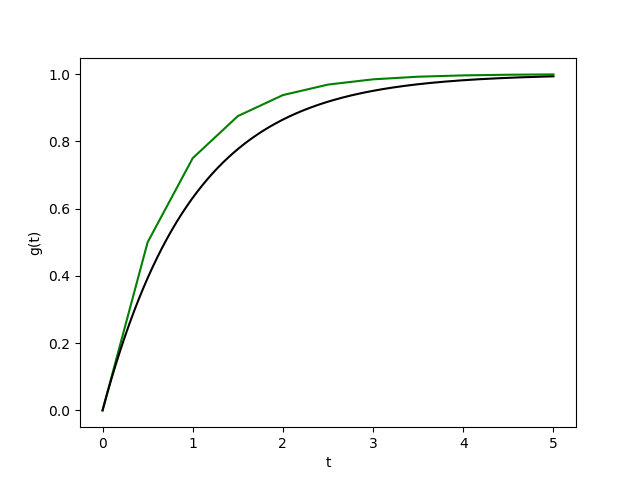

In [12]:
# Plot the result
ph = plt.plot(tv, yv, c='g');
    
# Plot the exact solution for comparison
tcv = np.arange(0, tmax, T/100);  # dense set of time points
ycv = 1 - np.exp(-tcv/(R*C));  # corresponding response values
ph0 = plt.plot(tcv, ycv, c='k');
plt.xlabel('t');  plt.ylabel('g(t)');

### Investigation

The script below investigates the standard Euler method for the problem, assuming different values of $T$.  As $T$ approaches zero the numerical approximation becomes more accurate.

In [1]:
%run src/labX_preamble.py  # For internal notebook functions

<IPython.core.display.Javascript object>


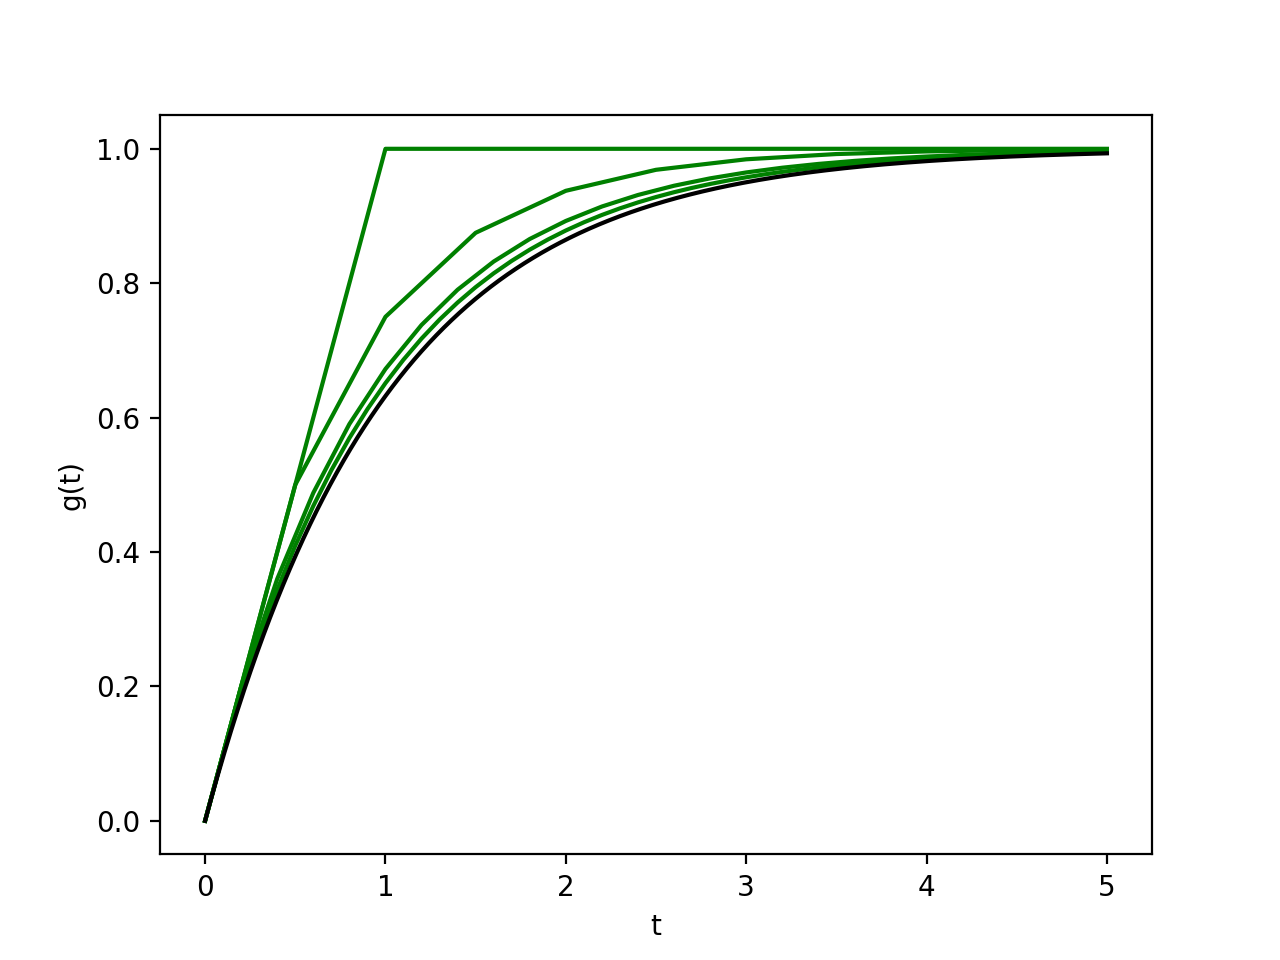

In [2]:
%%writefileexec src/lab_discdiffeq-1.py -s  # dump cell to file before execute

# Standard Euler metod for voltage across capacitor in series RC circuit versus
# input voltage for unit step input.  Initial rest conditions are assumed

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

# Assume R=C=1
R = 1.0;  C = 1.0;

# Show results for different values of T.  The solution becomes exact as T
# tends to zero
fh1 = plt.figure(1);
for T in [1.0, 0.5, 0.2, 0.1]:
    
    # Discrete time points to calculate (we want to plot from t=0 to t=tmax) 
    tmax = 5.001;
    tv = np.arange(0, tmax, T);
    N = len(tv);  # number of points
    
    # Create a vector yv = (y[0], y[1], ..., y[N-1]) to hold the values of y[n]
    # for nonnegative values of n.  We know that for n<0 the output is zero
    yv = np.zeros(tv.shape);
  
    # Calculate the value for y[0] and put it in vector yv
    yv[0] = 0;

    # Iterate the recursion for the required number of values
    for n in range(1,N):
        yv[n] = yv[n-1] + T/(R*C) - T/(R*C)*yv[n-1];
    
    # Plot the resulting points
    ph = plt.plot(tv, yv, c='g');
    
#end for

# Also plot the exact solution for comparison
tcv = np.arange(0, tmax, T/100);
ycv = 1 - np.exp(-tcv/(R*C));
ph = plt.plot(tcv, ycv, c='k');
plt.xlabel('t');  plt.ylabel('g(t)');

# Tasks

These tasks involve writing code, or modifying existing code, to meet the objectives described.

1.  If you use the backward difference approximation to the derivative
$$\frac{dy(t)}{dt} \approx \frac{y(t) - y(t-T)}{T} \quad \text{for small $T$}$$
instead of the forward difference, then you will arrive at the backward (or implicit) Euler numerical solution to the differential equation:
$$y[n+1] = \frac{1}{1+T/(RC)} y[n] + \frac{T/(RC)}{1+T/(RC)} x[n+1] = a y[n] + b x[n+1],$$
with 
$$a=\frac{1}{1+T/(RC)} \qquad \text{and} \qquad b=\frac{T/(RC)}{1+T/(RC)}.$$
Use this to estimate the step response of the circuit given, and investigate the approximation for the same values of $T$ used before.<br>
<br>
In terms of stability of approximation the backward Euler method is better than the forward Euler, but the order of their approximation errors is the same.  More advanced methods include the Runge–Kutta family.<br><br>

2.  Find the output when input is right-sided sinusoid $x(t) = \cos(\omega_0 t) u(t)$, again for $RC=1$ and under initial rest conditions $y(0) = 0$.  Make a plot of the response for frequencies $\omega_0 = 1$, $\omega_0 = 2$, and $\omega_0 = 5$ radians per second for the case of $T=0.01$ seconds.<br>
<br>
Observe that after the initial transient dies out the output is a sinusoid of the same frequency, but with a change in amplitude and a shift along the time axis.  For a fixed amplitude input the output amplitude decreases as the frequency goes up, which is why we call this a lowpass filter.<br><br>

3.  Formulate and investigate the forward Euler method to find the step response of a highpass filter, where $R$ and $C$ are swapped in the circuit.  You can again assume initial rest conditions.<br><br>

4.  Consider the output when input is right-sided sinusoid $x(t) = \cos(\omega_0 t) u(t)$ with $\omega_0 = 2$ radians per second and for $RC=1$.  Investigate the initial condition $y(0) = c$ for different values of $c$.  Make a plot of the response for $c = 0, 0.5, 1$ for the case of $T=0.01$.<br>
<br>
You should observe that after enough time has passed (i.e. after the transients have settled), the response becomes independent of the initial condition.<br><br>

5.  (Optional) Find the approximate output when the input is a two-sided sinusoid $x(t) = \sin(\omega_0 t)$, by formulating and applying recursion in both directions.  Note that the backward difference approximation to the derivative can be used to find an equation for the reverse iteration:
$$y[n-1] \approx y[n] - \frac{T}{RC} (x[n] - y[n]).$$
Investigate the initial condition $y(0) = c$ for different values of $c$.<br><br>

6.  (Optional) Try to find the exact step response of the RC lowpass filter using Sympy.

The wikipedia page https://en.wikipedia.org/wiki/Euler_method is a good place for details.  The description for the backward method https://en.wikipedia.org/wiki/Backward_Euler_method is also useful.